# Case Study - Tropical Forest

This is a demonstration notebook of using DeepForest to predict and train models for individual tree segmentation in drone imagery. The goal of this notebook is to orient users to the general DeepForest workflow. Due to data sharing agreements, the data in this example is not available. For more information on the data see the excellent: 

Aubry-Kientz, M., Dutrieux, R., Ferraz, A., Saatchi, S., Hamraz, H., Williams, J., Coomes, D., Piboule, A., Vincent, G., 2019. A Comparative Assessment of the Performance of Individual Tree Crowns Delineation Algorithms from ALS Data in Tropical Forests. Remote Sens. 11, 1086. https://doi.org/10.3390/rs11091086

I would like to thank the authors for sharing their data to test deepforest performance. 

In [1]:
#Load base packages
import numpy as np
from PIL import Image
import glob
import os
import re
import pandas as pd
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

#Load deepforest
#Optional comet_ml for tracking experiments
from comet_ml import Experiment
from deepforest import deepforest
from deepforest import preprocess
from deepforest import utilities
from deepforest import __version__

#Geospatial packages
import shapely
import geopandas
import rasterio

#Check version
print("This demo is run with deepforest version {}".format(__version__))

Using TensorFlow backend.


This demo is run with deepforest version 0.2.8


These are version warnings for tensorflow and numpy and can be ignored. Depending on your operating system and specific build, there may be more deprecation warnings. I am happy to field any questions on the DeepForest git repo issues page: https://github.com/weecology/DeepForest/issues  

When faced with a new dataset, the first step is usually test the performance of the prebuilt model. For information on how this model was created see https://deepforest.readthedocs.io/en/latest/getting_started.html

## Load DeepForest prebuilt model

Create a new deepforest object and download the latest release of the prebuilt NEON model from github: https://github.com/weecology/DeepForest/releases

In [2]:
model = deepforest.deepforest()

Reading config file: /Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/deepforest/data/deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.


These warnings are expected. We have decided not to suppress them in case they conflict with users processes in other codebases. As for DeepForest, they can be safely ignored. 

In [3]:
model.use_release()

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.2.1 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.2.1

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
model.__release_version__

'https://github.com/weecology/DeepForest/releases/tag/v0.2.1'

## Load RGB Raster

It is often useful to look at small piece of a large tile before performing predict_tile

In [5]:
raster_path = "/Users/ben/Dropbox/Weecology/Drone/ForBen/RGB_allPlots/RetroProj_cropped/RP_2015_P15.tif"
raster = Image.open(raster_path)
numpy_image = np.array(raster)
numpy_image.shape

(3470, 3530, 3)

Our image is 3440 by 3440 pixels with 3 channels

### Crop a small window

In [6]:
windows = preprocess.compute_windows(numpy_image, patch_size=800,patch_overlap=0.15)

windows is a sliding window object that holds the position of each crop

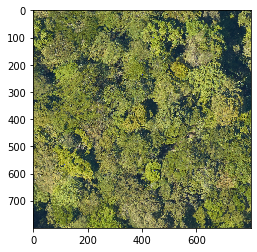

In [7]:
index = 9
crop = numpy_image[windows[index].indices()] 
crop.shape
plt.imshow(crop)

### Change from RGB to BGR channel order

Matplotlib and OpenCV differ in default channel orders. Using Image.open will yield RGB images, whereas keras-retinanet expects BGR images. Flip channel order using numpy. 

In [8]:
crop = crop[...,::-1] #keras-retinanet requires bluegreered channel order

## Predict from the prebuilt model

In [9]:
prediction = model.predict_image(raw_image = crop,return_plot=True, score_threshold=0.05)

/Users/ben/Documents/DeepForest_demos/env/lib/python3.7/site-packages/deepforest/deepforest.py:268: UserWarning: Input image has a size of (800, 800), but the release model was trained on crops of 400px x 400px, results may be poor.Use predict_tile for dividing large images into overlapping windows.
  "Use predict_tile for dividing large images into overlapping windows.".format(raw_image.shape[:2]))


In [ ]:
plt.imshow(prediction[...,::-1]) #show in rgb channel order

To get the bounding boxes as a dataframe, use return_plot=False

In [10]:
prediction_boxes = model.predict_image(raw_image = crop,return_plot=False, score_threshold=0.05)

In [ ]:
prediction_boxes.head()

In [ ]:
prediction_boxes.shape

In [ ]:
fig, axes, = plt.subplots(nrows=4,ncols=3, figsize=(30,30))
axes = axes.flatten()
for index in range(12):
    crop = numpy_image[windows[index].indices()] 
    #predict in bgr channel order
    prediction = model.predict_image(raw_image = crop[...,::-1],return_plot=True, score_threshold=0.05)
    #but plot in rgb channel order
    axes[index].imshow(prediction[...,::-1])

## Predict entire tile

The overall tile is too large to fit into memory. DeepForest will slide overlapping windows, same as the sized above, make a prediction on each window. Then reassemble and delete overlaps based on the highest scoring box. The reassembling process can be subtle, and requires the user to balance the amount of overlap (more predictions = slower), and the overall size of objects on interest.

In [ ]:
tile = model.predict_tile(raster_path,return_plot=True,patch_size=800,patch_overlap=0.15,iou_threshold=0.15)

In [ ]:
fig = plt.figure(figsize=(100,100))
plt.imshow(tile)
plt.savefig("/Users/Ben/Desktop/overlap30_iou20.png")

### Create shapefile of predictions

For this particular use case, we are interested in taking the bounding boxes and making a shapefile of bounding boxes. This section requires dependencies outside of DeepForest, and in particular geopandas can be annoying to install on windows due to GDAL. For this reason, these packages are not included in the main DeepForest install.

In [ ]:
boxes = model.predict_tile(raster_path,return_plot=False,patch_size=800,patch_overlap=0.15,iou_threshold=0.15)

In [ ]:
#Georeference.
#This isn't a true projection, but over small spatial scales it will be fine. Add the origin of the raster and multiply the box height and width by the cell size (m/cell).
#read in extent using rasterio
with rasterio.open(raster_path) as dataset:
    bounds = dataset.bounds
    pixelSizeX, pixelSizeY  = dataset.res

#subtract origin. Recall that numpy origin is top left! Not bottom left.
boxes["xmin"] = (boxes["xmin"] *pixelSizeX) + bounds.left
boxes["xmax"] = (boxes["xmax"] * pixelSizeX) + bounds.left
boxes["ymin"] = bounds.top - (boxes["ymin"] * pixelSizeY) 
boxes["ymax"] = bounds.top - (boxes["ymax"] * pixelSizeY) 

In [ ]:
# combine column to a shapely Box() object, save shapefile
boxes['geometry'] = boxes.apply(lambda x: shapely.geometry.box(x.xmin,x.ymin,x.xmax,x.ymax), axis=1)
boxes = geopandas.GeoDataFrame(boxes, geometry='geometry')

#set projection, (see dataset.crs) hard coded here
boxes.crs = {'init' :'epsg:32622'}
#get proj info see:https://gis.stackexchange.com/questions/204201/geopandas-to-file-saves-geodataframe-without-coordinate-system
prj = 'PROJCS["WGS_1984_UTM_Zone_22N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'
boxes.to_file('PrebuiltModel.shp', driver='ESRI Shapefile',crs_wkt=prj)

## Train Model

Beginning from the prebuilt model test above, we can train a model based on annotations from the study site in question. A seperate tile was hand-annotated using the program rectlabel. See https://deepforest.readthedocs.io/en/latest/training.html. There is no fixed number of annotations needed, it depends on the variability of the target dataset. Our experience is that ~1000 crowns is a good starting point. See Figure 8 from https://www.biorxiv.org/content/10.1101/790071v1.full. This example took about 4 hours to annotate.

![Training Annotations](figures/TrainingData.png)

Training configurations are stored in a deepforest_config.yml in the local directory, or a default config is used from install. These parameters can be accessed at runtime as well

In [ ]:
model.config

For more information on the parameter settings see https://deepforest.readthedocs.io/en/latest/training_config.html 

### Prepare annotation data for training

DeepForest trains on 400x400 pixel windows. The overall image is too large to fit into memory. We therefore need to split the annotations into windows and generate the crops for training

In [20]:
#Read xml and create pandas frame
annotation_paths = glob.glob("/Users/ben/Dropbox/Weecology/Drone/*.xml")
print(annotation_paths)
annotation_list = []
for xml in annotation_paths:
    xml_parse = utilities.xml_to_annotations(xml)

    #Write converted dataframe to file. Saved alongside the images. This is a temporary file for cutting windows.
    xml_parse.to_csv("FG_example.csv", index=False)

    #get plot name to match to RGB image
    plot_name = re.search("2015_(\w+).xml",xml).group(1)
    
    #Where to save cropped images
    crop_dir = "crops/"
    result = preprocess.split_raster(path_to_raster="/Users/ben/Dropbox/Weecology/Drone/ForBen/RGB_allPlots/RetroProj_cropped/RP_2015_{}.tif".format(plot_name),
                                     annotations_file="FG_example.csv",
                                     base_dir=crop_dir,
                                     patch_size=800,
                                     patch_overlap=0.05)
    annotation_list.append(result)

train_annotations = pd.concat(annotation_list)

#Split image crops into training and test. Normally these would be different tiles! Just as an example.
image_paths = train_annotations.image_path.unique()
test_paths = np.random.choice(image_paths, 3)
test_annotations = train_annotations.loc[train_annotations.image_path.isin(test_paths)]
train_annotations = train_annotations.loc[~train_annotations.image_path.isin(test_paths)]

#View output
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(test_annotations.shape[0]))

#save to file
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(crop_dir + "train.csv",index=False,header=False)
test_annotations.to_csv(crop_dir + "test.csv",index=False,header=False)

annotations_file= crop_dir + "train.csv"
test_file= crop_dir + "test.csv"

#Add the test annotations to the config, see https://deepforest.readthedocs.io/en/latest/training_config.html#validation-annotations-none
model.config["validation_annotations"] = test_file

['/Users/ben/Dropbox/Weecology/Drone/RP_2015_P6.xml', '/Users/ben/Dropbox/Weecology/Drone/RP_2015_P1.xml', '/Users/ben/Dropbox/Weecology/Drone/RP_2015_P10.xml']
There are 6741 training crown annotations
There are 225 test crown annotations


In [22]:
test_file

'crops/test.csv'

Before training lets get a bit of a baseline by getting the evaluation score on the test file using the prebuilt model.

In [ ]:
model.evaluate_generator(test_file)

Optionally create a comet experiment. Comet is a machine learning visualization dashboard with great tools and project tracking. There is a free tier for academics. 

In [ ]:
comet_experiment = Experiment(api_key="ypQZhYfs3nSyKzOfz13iuJpj2",
                                  project_name="frenchguiana", workspace="bw4sz")

#Train for a bit longer
model.config["epochs"] = 5
comet_experiment.log_parameters(model.config)

In [ ]:
model.train(annotations=annotations_file,input_type="fit_generator",comet_experiment=comet_experiment)
comet_experiment.end()

### Training Accurary

Use the model to predict the annotations used in training.

In [13]:
model.config["save_path"] = "."
model.evaluate_generator(annotations_file)

Running network: N/A% (0 of 72) |        | Elapsed Time: 0:00:00 ETA:  --:--:--

There are 1 unique labels: ['Tree'] 
Disabling snapshot saving


Running network: 100% (72 of 72) |#######| Elapsed Time: 0:02:25 Time:  0:02:25
Parsing annotations: 100% (72 of 72) |###| Elapsed Time: 0:00:00 Time:  0:00:00


6708 instances of class Tree with average precision: 0.4130
mAP using the weighted average of precisions among classes: 0.4130
mAP: 0.4130


0.4129755920515173

### Evaluation accuracy

For this example we held out a few crops from training. In general, we recommend that any validation data be from a seperate geographic tile.

In [ ]:
model.evaluate_generator(test_file)

A jump from 0.39 to 0.55 in ten minutes of training on a laptop. That's an improvement of 63% on out of sample data. Some caveats needed for the spatial autocorrelation in training and test data. We always recommend having geographically seperate data. 

## Predict new tile

In [ ]:
trained_model_tile = model.predict_tile(raster_path,return_plot=True,patch_size=800,patch_overlap=0.15,iou_threshold=0.15)

In [ ]:
fig = plt.figure(figsize=(100,100))
plt.imshow(trained_model_tile)
plt.savefig("/Users/Ben/Desktop/overlap30_iou20_trained.png")

In [ ]:
trained_model_boxes = model.predict_tile(raster_path,return_plot=False,patch_size=800,patch_overlap=0.15,iou_threshold=0.15)

In [ ]:
# Add raster extent to boxes to place in utm system. 
#This isn't a true projection, but over small spatial scales will be fine. Add the origin of the raster and multiply the box height and width by the cell size (m/cell).
#read in extent using rasterio
with rasterio.open(raster_path) as dataset:
    bounds = dataset.bounds
    pixelSizeX, pixelSizeY  = dataset.res

#subtract origin. Recall that numpy origin is top left! Not bottom left.
trained_model_boxes["xmin"] = (trained_model_boxes["xmin"] * pixelSizeX) + bounds.left
trained_model_boxes["xmax"] = (trained_model_boxes["xmax"] * pixelSizeX) + bounds.left
trained_model_boxes["ymin"] = bounds.top - (trained_model_boxes["ymin"] * pixelSizeY) 
trained_model_boxes["ymax"] = bounds.top - (trained_model_boxes["ymax"] * pixelSizeY)

In [ ]:
# combine lat and lon column to a shapely Box() object, save shapefile
trained_model_boxes['geometry'] = trained_model_boxes.apply(lambda x: shapely.geometry.box(x.xmin,x.ymin,x.xmax,x.ymax), axis=1)
trained_model_boxes = geopandas.GeoDataFrame(trained_model_boxes, geometry='geometry')
trained_model_boxes.crs = {'init' :'epsg:32622'}
#manually look up epsg
prj = 'PROJCS["WGS_1984_UTM_Zone_22N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'
trained_model_boxes.to_file('TrainedModel.shp', driver='ESRI Shapefile',crs_wkt=prj)

### View samples

Taking advantage of the fact that numpy slicing operates on the initial dataframe, we can specify the same crops as above and plot against the prebuilt model predictions boxes in a new color. 

In [ ]:
fig, axes, = plt.subplots(nrows=2,ncols=3, figsize=(30,30))
axes = axes.flatten()
for index in range(6):
    crop = numpy_image[windows[index].indices()] 
    #predict in bgr channel order
    prediction = model.predict_image(raw_image = crop[...,::-1],return_plot=True, score_threshold=0.05,color=(255,0,0))
    #but plot in rgb channel order
    axes[index].imshow(prediction[...,::-1])
    axes[index].get_yaxis().set_visible(False)
    axes[index].get_xaxis().set_visible(False)
fig.tight_layout() 
plt.show()
fig.savefig("predictions.svg")

# Local annotations only

It is useful to know whether the local annotations, with no pretraining weights from the prebuilt model, perform as well.

In [ ]:
local_model = deepforest.deepforest()
comet_experiment = Experiment(api_key="ypQZhYfs3nSyKzOfz13iuJpj2",
                                  project_name="frenchguiana", workspace="bw4sz")

#Train for a bit longer
local_model.config["epochs"] = 5
model.config["validation_annotations"] = test_file
comet_experiment.log_parameters(local_model.config)
local_model.train(annotations=annotations_file,input_type="fit_generator",comet_experiment=comet_experiment)
comet_experiment.end()
local_model.evaluate_generator(test_file)

In [ ]:
trained_model_boxes = local_model.predict_tile(raster_path,return_plot=False,patch_size=800,patch_overlap=0.15,iou_threshold=0.15)
# Add raster extent to boxes to place in utm system. 
#This isn't a true projection, but over small spatial scales will be fine. Add the origin of the raster and multiply the box height and width by the cell size (m/cell).
#read in extent using rasterio

with rasterio.open(raster_path) as dataset:
    bounds = dataset.bounds
    pixelSizeX, pixelSizeY  = dataset.res

#subtract origin. Recall that numpy origin is top left! Not bottom left.
trained_model_boxes["xmin"] = (trained_model_boxes["xmin"] * pixelSizeX) + bounds.left
trained_model_boxes["xmax"] = (trained_model_boxes["xmax"] * pixelSizeX) + bounds.left
trained_model_boxes["ymin"] = bounds.top - (trained_model_boxes["ymin"] * pixelSizeY) 
trained_model_boxes["ymax"] = bounds.top - (trained_model_boxes["ymax"] * pixelSizeY)

# combine lat and lon column to a shapely Box() object, save shapefile
trained_model_boxes['geometry'] = trained_model_boxes.apply(lambda x: shapely.geometry.box(x.xmin,x.ymin,x.xmax,x.ymax), axis=1)
trained_model_boxes = geopandas.GeoDataFrame(trained_model_boxes, geometry='geometry')
trained_model_boxes.crs = {'init' :'epsg:32622'}
#manually look up epsg
prj = 'PROJCS["WGS_1984_UTM_Zone_22N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'
trained_model_boxes.to_file('LocalModel.shp', driver='ESRI Shapefile',crs_wkt=prj)